#  HEP-Th Runtime experiments

In this notebook we measure the runtime of forward, backward, and inference computations for graph edit networks (without edge filtering, with edge filtering, and with a constant number of maximum edge-edited nodes) on realistic graphs from the HEP-Th dataset.

In [1]:
import time
import numpy as np
import torch
import pytorch_graph_edit_networks as gen
import hep_th

# model parameters
num_layers = 3
dim_hid = 64
nonlin = torch.nn.Tanh()

# initialize model, one without edge filters, one with edge filters, but no limit, and one
# with limit
filter_options = [False, True, 538]
# set up model names for result storage
model_names = ['no_filter', 'flex_filter', 'const_filter']
comp_names  = ['forward', 'backward', 'inference']
headers = ['sizes']
for model_name in model_names:
    for comp_name in comp_names:
        headers.append('%s_%s' % (model_name, comp_name))

max_past = 12


# set up a list of all experimental settings
month_tuples = []
for year in range(1992,2003+1):
    max_month = 12
    if year == 2003:
        max_month = 4
    for month in range(1, max_month+1):
        month_tuples.append((year, month))
settings = []
for past in range(1, max_past+1):
    for t in range(past, len(month_tuples)):
        settings.append((month_tuples[t][0], month_tuples[t][1], past))

# try to load prior runtime results from disk
import os
if os.path.exists('hep_th_runtimes.csv'):
    data     = np.loadtxt('hep_th_runtimes.csv', delimiter='\t', skiprows = 1)
    sizes    = data[:, 0]
    Runtimes = data[:, 1:].T
else:
    Runtimes = np.zeros((len(filter_options) * 3, len(settings)))
    # compute graph sizes
    sizes = np.zeros(len(settings))
    s = 0
    for past in range(1, max_past+1):
        for t in range(past, len(month_tuples)):
            past_months = month_tuples[(t-past):t]
            A, I = hep_th.read_graph_from_csv('hep-th/graphs/%d_%d.csv' % (past_months[0][0], past_months[0][1]))
            for past_month in past_months[1:]:
                # parse the current graph from CSV data
                B, J = hep_th.read_graph_from_csv('hep-th/graphs/%d_%d.csv' % (past_month[0], past_month[1]))
                # add B, J to A, I
                A, I = hep_th.add_graph(A, I, B, J)
            sizes[s] = len(I)
            s += 1

# check which models still need to be processed
remaining_models = []
for model_idx in range(len(filter_options)):
    if np.any(Runtimes[model_idx*3:(model_idx+1)*3, :] < 1E-8):
        remaining_models.append(model_idx)
# iterate over all models
for model_idx in remaining_models:
    print('processing edge filter option %s' % str(filter_options[model_idx]))
    # check all remaining experimental settings
    remaining_settings = np.where(np.any(Runtimes[model_idx*3:(model_idx+1)*3, :] < 1E-8, 0))[0]
    # iterate over all possible experimental settings
    last_past = -1
    for s in remaining_settings:
        year, month, past = settings[s]
        if past != last_past:
            if last_past > 0:
                print('required a total time of %g seconds' % np.sum(Runtimes[(model_idx*3):(model_idx*3+3), last_s:s]))
            print('considering %d past months for graph construction' % past)
            last_past = past
            last_s = s
        # initialize a new network
        net = gen.GEN(num_layers = num_layers, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = filter_options[model_idx])
        # compute a forward pass for loss computation
        start_time = time.time()
        loss = hep_th.compute_loss(net, year, month, past = past)
        Runtimes[model_idx * 3 + 0, s] = time.time() - start_time
        # compute gradient
        start_time = time.time()
        loss.backward()
        Runtimes[model_idx * 3 + 1, s] = time.time() - start_time
        # switch to eval mode and do another forward pass
        net.eval()
        start_time = time.time()
        loss = hep_th.compute_loss(net, year, month, past = past)
        Runtimes[model_idx * 3 + 2, s] = time.time() - start_time
        # store results
        np.savetxt('hep_th_runtimes.csv', np.concatenate((np.expand_dims(sizes, 1), Runtimes.T), 1), delimiter='\t', header='\t'.join(headers), fmt='%g', comments = '')

processing edge filter option False
considering 10 past months for graph construction
required a total time of 13573 seconds
considering 11 past months for graph construction
processing edge filter option True
considering 1 past months for graph construction
required a total time of 30.7319 seconds
considering 2 past months for graph construction
required a total time of 28.5075 seconds
considering 3 past months for graph construction
required a total time of 52.8381 seconds
considering 4 past months for graph construction
required a total time of 76.0885 seconds
considering 5 past months for graph construction
required a total time of 97.9679 seconds
considering 6 past months for graph construction
required a total time of 116.482 seconds
considering 7 past months for graph construction
required a total time of 133.473 seconds
considering 8 past months for graph construction
required a total time of 147.683 seconds
considering 9 past months for graph construction
required a total time

log-fit for forward computation of no_filter model: log(y) = 1.66529 * log(x) + -12.0214
log-fit for forward computation of flex_filter model: log(y) = 1.32117 * log(x) + -10.4584
log-fit for forward computation of const_filter model: log(y) = 1.33302 * log(x) + -10.4088
log-fit for backward computation of no_filter model: log(y) = 4.10825 * log(x) + -26.9001
log-fit for backward computation of flex_filter model: log(y) = 0.93353 * log(x) + -11.883
log-fit for backward computation of const_filter model: log(y) = 1.28752 * log(x) + -12.707
log-fit for inference computation of no_filter model: log(y) = 1.69191 * log(x) + -12.1958
log-fit for inference computation of flex_filter model: log(y) = 1.32336 * log(x) + -10.4626
log-fit for inference computation of const_filter model: log(y) = 1.31487 * log(x) + -10.2706


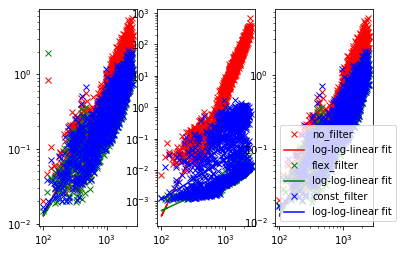

In [2]:
# load results again
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
data     = np.loadtxt('hep_th_runtimes.csv', delimiter='\t', skiprows = 1)
sizes    = data[:, 0]
Runtimes = data[:, 1:].T

model_names = ['no_filter', 'flex_filter', 'const_filter']
colors = 'rgb'
comp_names  = ['forward', 'backward', 'inference']
for c in range(len(comp_names)):
    plt.subplot(130 + c + 1)
    for model_idx in range(len(model_names)):
        # perform a log-log linear fit
        y = Runtimes[model_idx * 3 + c, :]
        x = sizes[y > 1E-8]
        y = y[y > 1E-8]
        w, b, _, _, _ = linregress(np.log(x), np.log(y))
        print('log-fit for %s computation of %s model: log(y) = %g * log(x) + %g' % (comp_names[c], model_names[model_idx], w, b))
        # plot the data and the log fit
        plt.loglog(x, y, colors[model_idx] + 'x')
        plt.loglog(x, np.power(x, w) * np.exp(b), colors[model_idx] + '-')
legend_strings = []
for model_idx in range(len(model_names)):
    legend_strings.append(model_names[model_idx])
    legend_strings.append('log-log-linear fit')
plt.legend(legend_strings)
plt.show()